In [334]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso

import pysindy as ps
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [335]:
from stesml.data_tools import get_scenario_index
from stesml.data_tools import get_train_and_val_index
from stesml.data_tools import load_data

In [336]:
data_dir = "../data/Sulfur_Models/heating/heating_all"

In [391]:
t_min = 1
t_max = -1

In [392]:
scenario_index = get_scenario_index(data_dir)

In [393]:
train_index, val_index = get_train_and_val_index(scenario_index, random_state=5)

In [394]:
train_data_ = load_data(scenario_index, train_index, t_min=t_min, t_max=t_max)
train_df = train_data_[['Tw','Ti','Tavg']]
train_df.index = train_data_['flow-time']
train_df

,Tw,Ti,Tavg
flow-time,,,
1.010680,540,400.0,400.874253
1.110680,540,400.0,400.920411
1.210680,540,400.0,400.964261
1.310680,540,400.0,401.006935
1.410680,540,400.0,401.048340
...,...,...,...
7199.604681,460,400.0,429.384154
7199.704681,460,400.0,429.384296
7199.804681,460,400.0,429.384439


In [395]:
val_data_ = load_data(scenario_index, val_index, t_min=t_min, t_max=t_max)
val_df = val_data_[['Tw','Ti','Tavg']]
val_df.index = val_data_['flow-time']
val_df

,Tw,Ti,Tavg
flow-time,,,
1.066673,560,440.0,440.778176
1.166673,560,440.0,440.817492
1.266673,560,440.0,440.855069
1.366673,560,440.0,440.891111
1.466673,560,440.0,440.925782
...,...,...,...
359.669535,520,440.0,446.627400
359.769535,520,440.0,446.627971
359.869535,520,440.0,446.628541


In [396]:
train_data = list()
train_index = list()
for idx, grp in train_df.groupby(["Tw", "Ti"]):
    train_data.append(grp.values)
    train_index.append(grp.index.values)

In [397]:
val_data = list()
val_index = list()
for idx, grp in val_df.groupby(["Tw", "Ti"]):
    val_data.append(grp.values)
    val_index.append(grp.index.values)

In [444]:
poly_library = ps.feature_library.PolynomialLibrary(degree=2)
optimizer = ps.STLSQ(threshold=0,normalize_columns=True,verbose=True)
model = ps.SINDy(optimizer=optimizer, feature_names=['Tw','Ti','Ts'], feature_library=poly_library)

In [445]:
model.fit(train_data, t=train_index, multiple_trajectories=True)

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 4.9813e+02 ... 2.0883e+01 ...         30 ... 5.1901e+02


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['Tw', 'Ti', 'Ts'],
      optimizer=STLSQ(normalize_columns=True, threshold=0, verbose=True))

In [459]:
model.print(precision=7)

(Tw)' = 0.0000000
(Ti)' = 0.0000000
(Ts)' = 0.0757478 1 + -0.0001977 Tw + 0.0001893 Ti + -0.0002806 Ts + 0.0000006 Tw^2 + 0.0000003 Tw Ti + -0.0000009 Tw Ts + 0.0000010 Ti^2 + -0.0000024 Ti Ts + 0.0000017 Ts^2


In [447]:
n_cases = len(val_data)

In [462]:
predictions = list()
Tdot_predictions = list()
for i in range(n_cases):
    prediction = model.simulate(x0=np.array(val_data[i][0]).reshape(3),t=val_index[i])
    Tdot_prediction = model.predict(prediction)
    predictions.append(prediction)
    Tdot_predictions.append(Tdot_prediction)

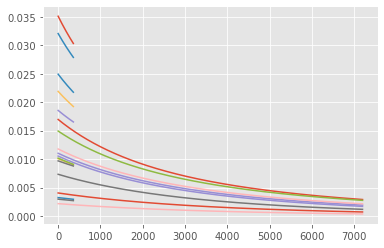

In [464]:
for i in range(n_cases):
    plt.plot(val_index[i], Tdot_predictions[i][:,2])

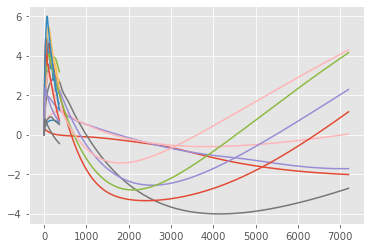

In [449]:
for i in range(n_cases):
    plt.plot(val_index[i], val_data[i][:,2] - predictions[i][:,2])

In [477]:
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_Ac

Ac = get_Ac()
As = get_As()

In [503]:
T = list()
Tw = list()
Ti = list()
Tdot = list()

for i in range(n_cases):
    Tw += predictions[i][:,0].tolist()
    Ti += predictions[i][:,1].tolist()
    T += predictions[i][:,2].tolist()
    Tdot += Tdot_predictions[i][:,2].tolist()

In [504]:
m = list()
Cp = list()
for i in range(len(T)):
    m.append(get_m(T[i], Ac))
    Cp.append(get_Cp(T[i]))

In [505]:
T = np.array(T)
Tw = np.array(Tw)
Ti = np.array(Ti)
m = np.array(m)
Cp = np.array(Cp)

In [507]:
h = m*Cp*Tdot/(As*(Tw-T))

In [ ]:
for i in range(n_cases):
    val_index_joined += val_index[i].tolist()

In [ ]:
plt.plot(val_index[i], val_data[i][:,2] - predictions[i][:,2])

In [450]:
predictions_joined = list()
val_data_joined = list()

for i in range(n_cases):
    val_data_joined += val_data[i][:,2].tolist()
    predictions_joined += predictions[i][:,2].tolist()

In [451]:
r2 = r2_score(val_data_joined, predictions_joined)
rmse = mean_squared_error(val_data_joined, predictions_joined, squared=False)
print(f'RMSE: {rmse}, R2: {r2}')

RMSE: 2.0037994934194914, R2: 0.9983082004126498


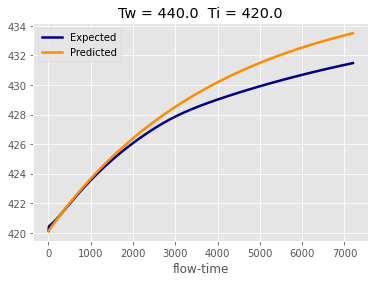

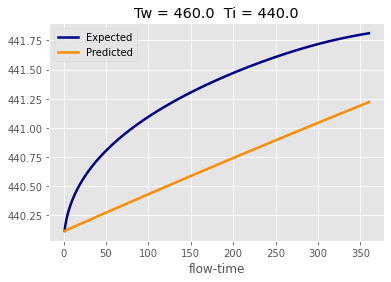

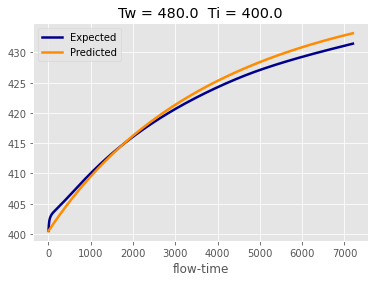

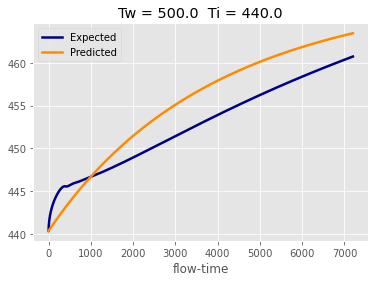

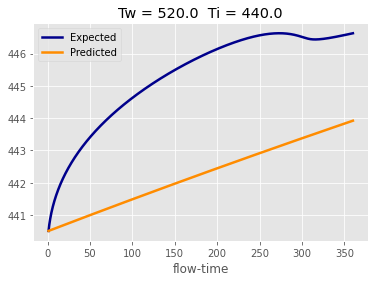

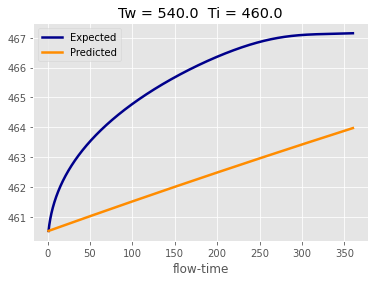

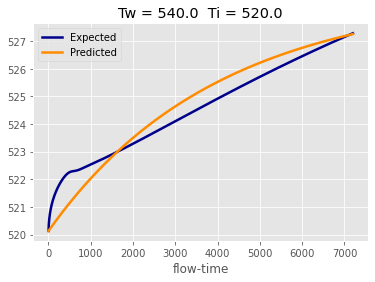

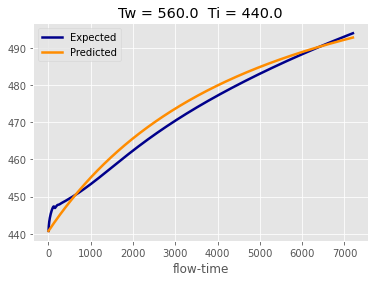

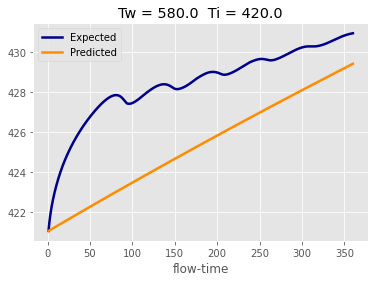

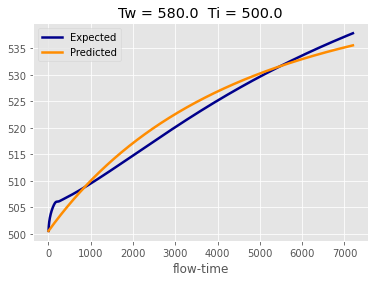

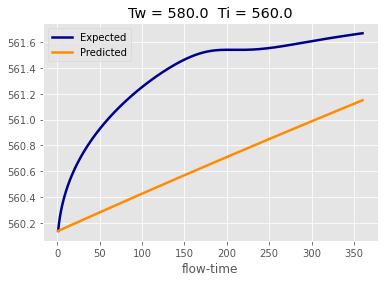

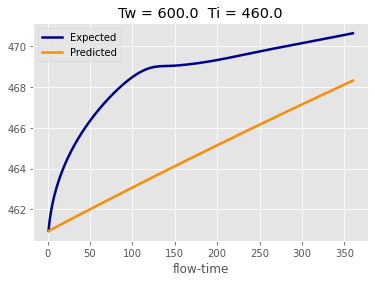

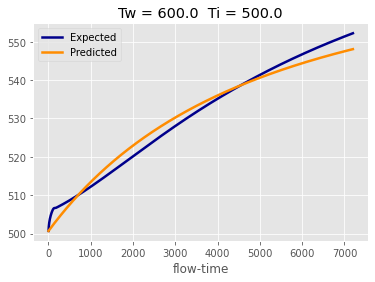

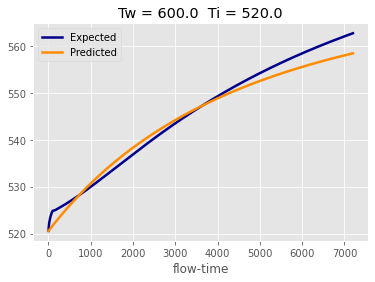

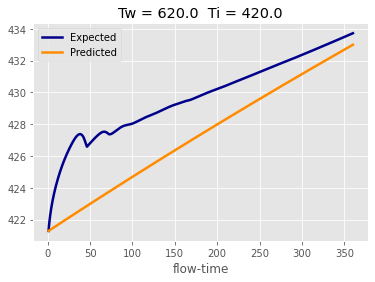

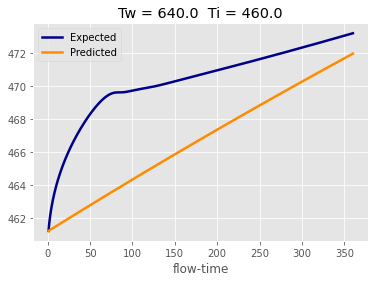

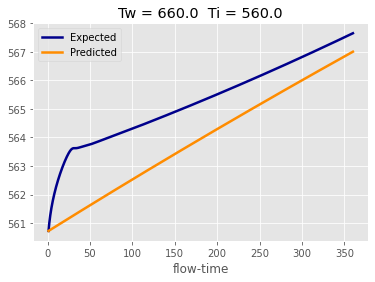

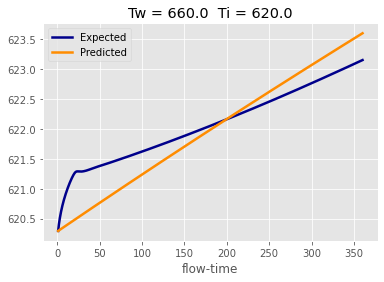

In [452]:
plt.style.use('ggplot')
for i in range(len(val_data_list)):
    Tw = val_data_list[i][:,0][0]
    Ti = val_data_list[i][:,1][0]
    plt.plot(val_index[i], val_data[i][:,2], linewidth=2.5, c='DarkBlue', label='Expected')
    plt.plot(val_index[i], predictions[i][:,2], linewidth=2.5, c='DarkOrange', label='Predicted')
    plt.xlabel('flow-time')
    plt.title(f'Tw = {Tw}  Ti = {Ti}')
    plt.legend()
    plt.show()